In [1]:
!pip install adjustText

from adjustText import adjust_text
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
import seaborn as sns

In [2]:
# ============= CONFIG =============
TRIPS_PER_MONTH  = 18
DELAY_FACTOR_CAR = 1.35

# -------- locate BASE & DATA (works in notebook or script) --------
try:
    BASE = Path(__file__).resolve().parent        # .py script
except NameError:
    BASE = Path.cwd()                              # notebook / REPL

DATA_CANDIDATES = [BASE / "data", BASE.parent / "data"]
DATA = next((d for d in DATA_CANDIDATES if d.exists()), BASE / "data")

CITY_CSV = Path("../processed_data/DelftTravelData_withCosts.csv")
PUMP_1x1 = Path("../processed_data/Avg_PumpPrice_Monthly.csv")
CAR_INFO_CANDS = [Path("../base data/Car_Information.csv")]

# ============= HELPERS =============
def must_exist(p: Path):
    if not p.exists():
        raise FileNotFoundError(str(p))

def smart_to_num(s: pd.Series) -> pd.Series:
    """
    Robust numeric parser:
    - strip € and NBSP
    - convert comma-decimal -> dot
    - remove thousands separators (space or dot between 3-digit groups)
    - keep the final decimal dot
    """
    s = s.astype(str).str.strip()
    s = s.str.replace("€", "", regex=False).str.replace("\u00A0", " ", regex=False)
    s = s.str.replace(",", ".", regex=False)  # decimal comma -> dot
    # remove thousand separators like "1 234" or "1.234" but keep decimal dot
    s = s.str.replace(r"(?<=\d)[\s\.](?=\d{3}(?:\D|$))", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def pick(df: pd.DataFrame, *alts) -> str | None:
    """Return the first matching column by normalized name; else None."""
    def norm(x): return re.sub(r"[^a-z0-9]", "", str(x).lower())
    cols_norm = {norm(c): c for c in df.columns}
    for a in alts:
        na = norm(a)
        if na in cols_norm:
            return cols_norm[na]
    return None

def load_pump_avg(path: Path) -> float:
    """Read any 1x1-ish CSV and return the first numeric found."""
    df = pd.read_csv(path, header=None, dtype=str)

    nums = []
    for v in df.values.flatten():
        s = ("" if pd.isna(v) else str(v)).strip().replace(",", ".")
        # accept ONLY pure numbers like 1.88 / 2 / 2.056 (no letters around)
        if re.fullmatch(r"[-+]?\d+(?:\.\d+)?", s):
            try:
                nums.append(float(s))
            except ValueError:
                pass

    # prefer a realistic fuel price range (€/L)
    for x in nums:
        if 0.5 <= x <= 5.0:
            return x
    if nums:
        return nums[-1]  # fallback: last numeric
    raise ValueError(f"No numeric fuel price found in {path.name}")

def load_car_info(candidates) -> dict:
    p = next((c for c in candidates if c.exists()), None)
    if p is None:
        raise FileNotFoundError(f"Car information file not found. Checked: {[str(x) for x in candidates]}")
    info = pd.read_csv(p, sep=";", engine="python")
    info.columns = [c.strip() for c in info.columns]
    if not {"Car information","Value"}.issubset(info.columns):
        raise ValueError(f"{p.name} must have columns 'Car information' and 'Value'")

    def norm(s: str) -> str: return re.sub(r"[ \-_/\.]", "", str(s).strip().lower())
    kv = {norm(k): str(v).replace(",", ".") for k, v in zip(info["Car information"], info["Value"])}

    # ---- consumption: accept either km/L or L/km ----
    cons_L_per_km = None
    for key in ["kilometersliter","kml","kmperliter","kilometerperliter","lperkm","literperkm","lkm"]:
        if key in kv:
            val = float(kv[key])
            if key in {"lperkm","literperkm","lkm"} or val <= 0.5:
                # Already L/km (typical ~0.04–0.12)
                cons_L_per_km = val
            else:
                # km/L (typical ~10–25) → convert to L/km
                cons_L_per_km = 1.0 / val
            break
    if cons_L_per_km is None:
        raise ValueError("Fuel consumption not found (expected km/L or L/km).")

    # maintenance €/month
    maint = None
    for key in ["maintenancecostsmonth","maintanencecostsmonth","maintenancepermonth","maintenancecostpermonth"]:
        if key in kv:
            maint = float(kv[key]); break
    if maint is None:
        raise ValueError("MaintenanceCosts/Month not found in car info.")

    return {"cons_L_per_km": cons_L_per_km, "maint_fixed_per_month": maint}



In [3]:
# Load and verify input data
must_exist(CITY_CSV)
must_exist(PUMP_1x1)

# Read city travel data and pump price
city_data = pd.read_csv(CITY_CSV)

# Normalize column names (convert to lowercase, remove spaces)
city_data.columns = city_data.columns.str.lower().str.replace(' ', '_')

pump_price = load_pump_avg(PUMP_1x1)
car_info = load_car_info(CAR_INFO_CANDS)

# Calculate costs per trip
cons_L_per_km = car_info['cons_L_per_km']
maint_fixed = car_info['maint_fixed_per_month']

# Use the correct column names from the data
cities = city_data['city'].unique()
distances = city_data['mean_distance_to_delft']
times = city_data['mean_time_to_delft']

# Calculate costs and times per month
costs_per_month = []
times_per_month = []

for city in cities:
    city_mask = city_data['city'] == city
    
    # Get distance and time for this city
    dist = distances[city_mask].iloc[0]
    time = times[city_mask].iloc[0]
    
    # Get additional monthly costs for this city
    roadtax = city_data.loc[city_mask, 'roadtax_eur_per_month'].iloc[0]
    insurance = city_data.loc[city_mask, 'insurance_eur_per_month'].iloc[0]
    parking = city_data.loc[city_mask, 'parkingpermit_eur_per_month'].iloc[0]
    
    # Calculate monthly costs
    fuel_cost = dist * cons_L_per_km * pump_price * 2 * TRIPS_PER_MONTH  # Round trip
    total_cost = fuel_cost + maint_fixed + roadtax + insurance + parking  # Include all monthly costs
    
    # Calculate monthly time (with delay factor for traffic)
    total_time = time * 2 * TRIPS_PER_MONTH * DELAY_FACTOR_CAR  # Round trip with delay
    
    costs_per_month.append(total_cost)
    times_per_month.append(total_time)

# Create DataFrames for costs and times
cost_df = pd.DataFrame({
    'City': cities,
    'CarCost_EUR_per_month': costs_per_month
})

time_df = pd.DataFrame({
    'City': cities,
    'CarTime_min_per_month': times_per_month
})

# Save individual files
cost_df.to_csv("../processed_data/CarCost_1xN.csv", index=False)
time_df.to_csv("../processed_data/CarTime_1xN.csv", index=False)

# Create and save combined tidy data
tidy_df = pd.merge(cost_df, time_df, on='City')
tidy_df.to_csv("../processed_data/CarCostTime_tidy.csv", index=False)

# Update our working DataFrame to use the new tidy data
df = tidy_df.copy()
df = df.sort_values("CarCost_EUR_per_month", ascending=False)  # Sort as before

In [4]:
# Load tTidy data
df = pd.read_csv("../processed_data/CarCostTime_tidy.csv")

# Optional: sort by cost for clarity
df = df.sort_values("CarCost_EUR_per_month", ascending=False)

In [5]:

def bar_with_labels(df, x_col, y_col, title, y_label, color="royalblue"):
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = ax.bar(df[x_col], df[y_col], color=color, edgecolor="black", linewidth=0.6)

    # Title & axes
    ax.set_title(title, fontsize=14, weight="bold", pad=8)
    ax.set_ylabel(y_label)
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha="right")

    # Grid & axis styling
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    ax.set_axisbelow(False)  # gridlines ABOVE bars
    ax.grid(axis="y", linestyle="--", linewidth=0.9, alpha=0.9, color="gray", zorder=5)
    # Value labels on top of bars
    ax.bar_label(bars, labels=[f"{v:.2f}" for v in df[y_col]], padding=3, fontsize=9)
    ax.set_ylim(0, df[y_col].max() * 1.15)  # headroom for labels

    plt.tight_layout()
    plt.show()






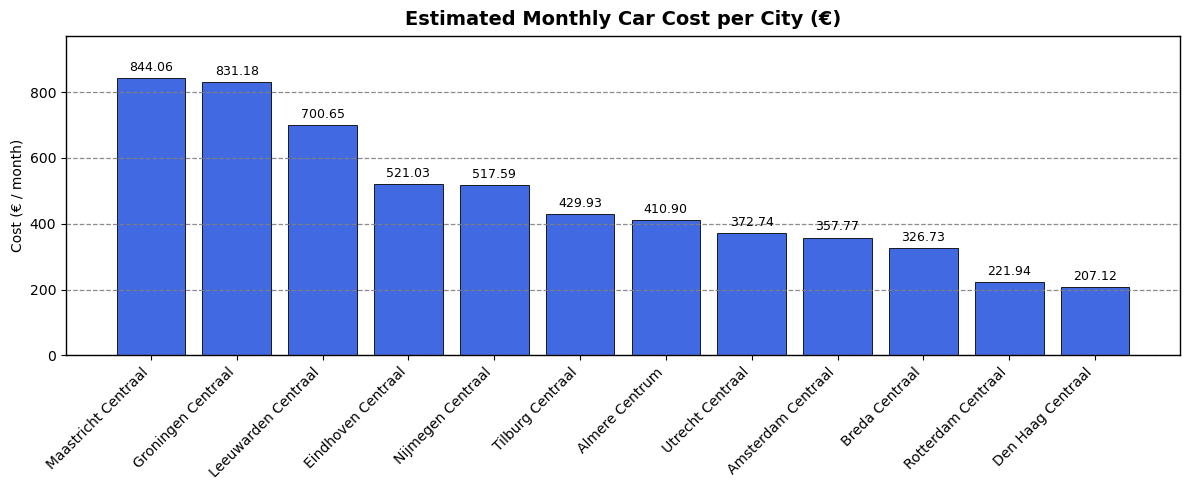

In [6]:
bar_with_labels(
    df,
    x_col="City",
    y_col="CarCost_EUR_per_month",
    title="Estimated Monthly Car Cost per City (€)",
    y_label="Cost (€ / month)",
    color="royalblue"
)


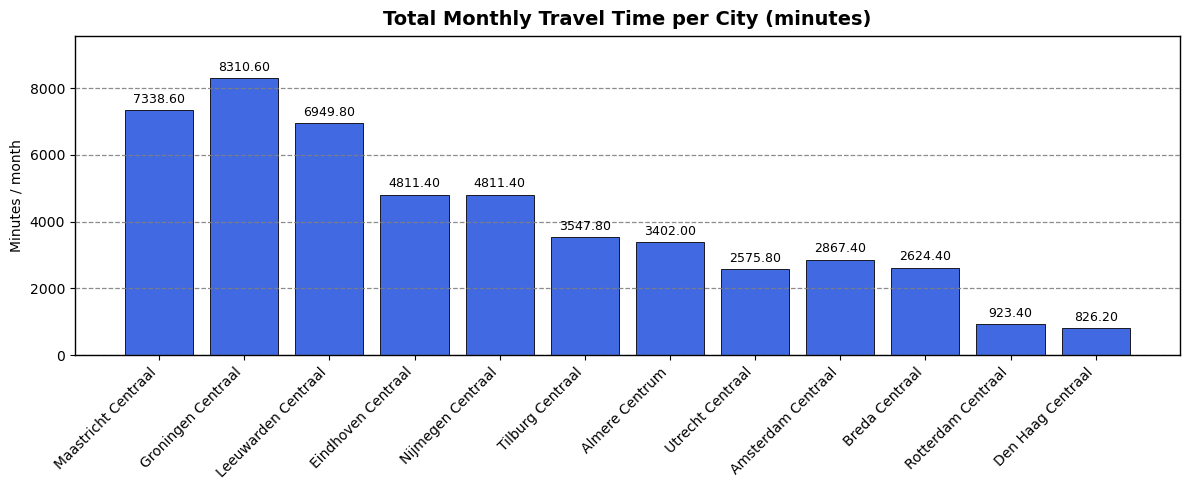

In [7]:
bar_with_labels(
    df,
    x_col="City",
    y_col="CarTime_min_per_month",
    title="Total Monthly Travel Time per City (minutes)",
    y_label="Minutes / month",
    color="royalblue"
)



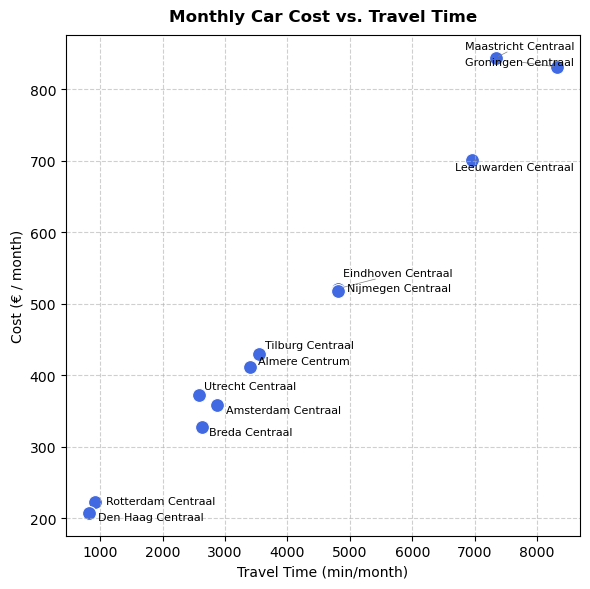

In [8]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="CarTime_min_per_month",
    y="CarCost_EUR_per_month",
    data=df,
    s=100,
    color="royalblue"
)

texts = []
for i, row in df.iterrows():
    texts.append(
        plt.text(
            row.CarTime_min_per_month,
            row.CarCost_EUR_per_month,
            row.City,
            fontsize=8
        )
    )

# Automatically adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Add grid and axis styling
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.title("Monthly Car Cost vs. Travel Time", fontsize=12, weight='bold', pad=10)
plt.xlabel("Travel Time (min/month)")
plt.ylabel("Cost (€ / month)")
plt.tight_layout()
plt.show()



